In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session


In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
#blueprint #1 is measurement shelf
#blueprint #2 is station shelf

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspect the attributes of Measurement & Station
print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


Query Start Date: 2016-08-23 00:00:00


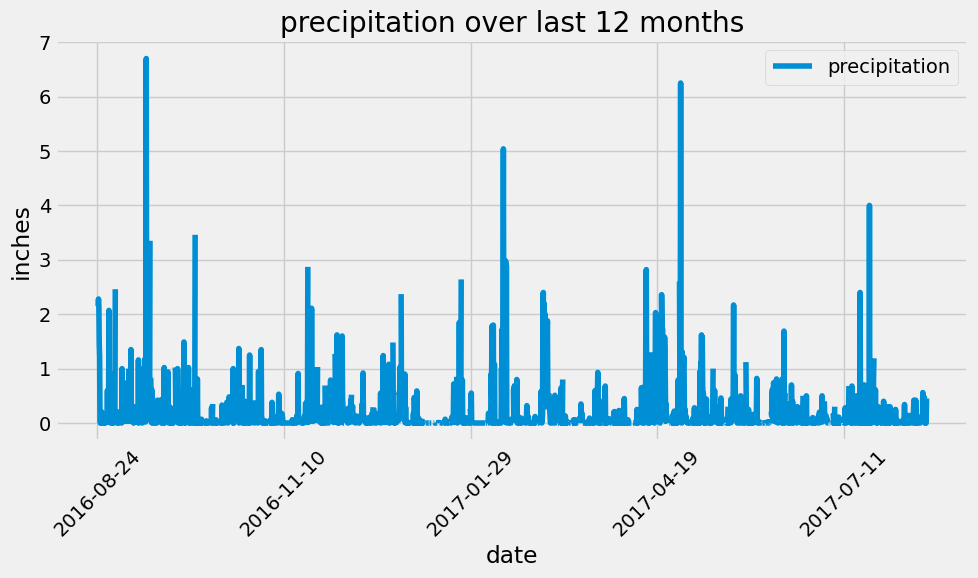

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(recent_date[0], "%Y-%m-%d")
query_start_date = last_date - dt.timedelta(days=365)

print(f"Query Start Date: {query_start_date}")

# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date >= query_start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_query, columns=['date', 'precipitation'])


# Sort the dataframe by date
precipitation_df.set_index('date', inplace=True)
precipitation_df.sort_index(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10,6))
plt.title('precipitation over last 12 months')
plt.ylabel('inches')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).distinct().count()
print(station_count)

9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()
for row in station_activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average
most_active_station = station_activity[0][0]

temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

print(temp_stats)

[(54.0, 85.0, 71.66378066378067)]


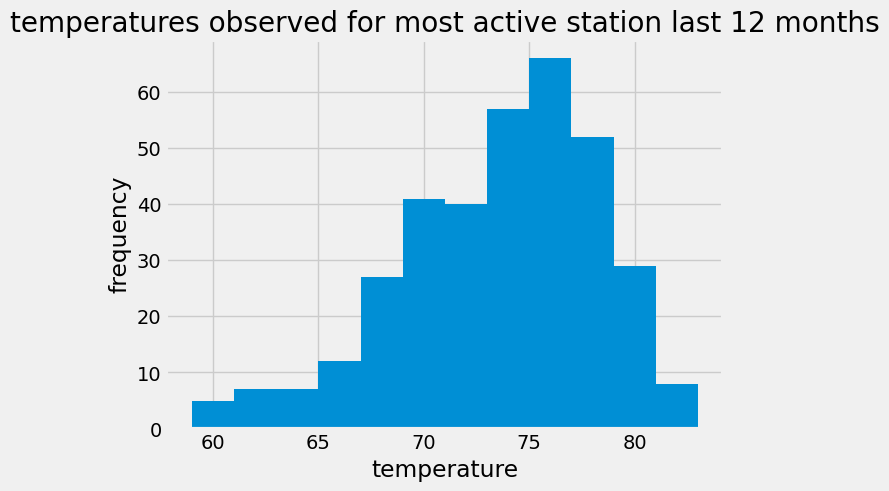

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= query_start_date)\
    .all()

# convert list of tuples into a simple list for plotting
tobs_list = [ t[0] for t in tobs_data ]

# plot the histogram
plt.hist(tobs_list, bins=12)
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.title('temperatures observed for most active station last 12 months')
plt.tight_layout
plt.show()


# Close Session

In [40]:
# Close Session
session.close()